In [2]:
#https://github.com/pomber/covid19
import numpy as np
import pandas as pd
from fbprophet import Prophet
import json, requests

from scipy import optimize
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate

In [3]:
hoje = str(datetime.datetime.today().date())
amanha = str(datetime.datetime.today().date() + datetime.timedelta(days=1))
ontem = str(datetime.datetime.today().date() - datetime.timedelta(days=1))

df = pd.read_csv('dados/corona_world_data.csv', sep=',')
df['data'] = df['data'].astype('datetime64[ns]')

df_paises = pd.read_csv('dados/paises_mundo_2019.csv')
# df[df['pais']=='Brazil'].tail()
df_paises.tail()

,pais,iso2,iso3,lat,long,flag,LocID,VarID,Variant,Time,PopMale,PopFemale,PopTotal,PopDensity
174,Angola,AO,AGO,-12.5,18.5,https://raw.githubusercontent.com/NovelCOVID/A...,24,2,Medium,2019,15744.779,16080.520,31825.299,25.528
175,Andorra,AD,AND,42.5,1.6,https://raw.githubusercontent.com/NovelCOVID/A...,20,2,Medium,2019,NaN,NaN,77.146,164.140
176,Algeria,DZ,DZA,28.0,3.0,https://raw.githubusercontent.com/NovelCOVID/A...,12,2,Medium,2019,21749.666,21303.388,43053.054,18.076
177,Albania,AL,ALB,41.0,20.0,https://raw.githubusercontent.com/NovelCOVID/A...,8,2,Medium,2019,1466.785,1414.128,2880.913,105.143
178,Afghanistan,AF,AFG,33.0,65.0,https://raw.githubusercontent.com/NovelCOVID/A...,4,2,Medium,2019,19529.727,18512.030,38041.757,58.269


In [4]:
paises = df['pais'].unique()
paises

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

----------------------------
### Monitoramento

In [5]:
#selecione os países a serem monitorados e comparados
paisesMonitorados = ['Brazil','Italy', 'United Kingdom', 'Spain', 'US', 'China']

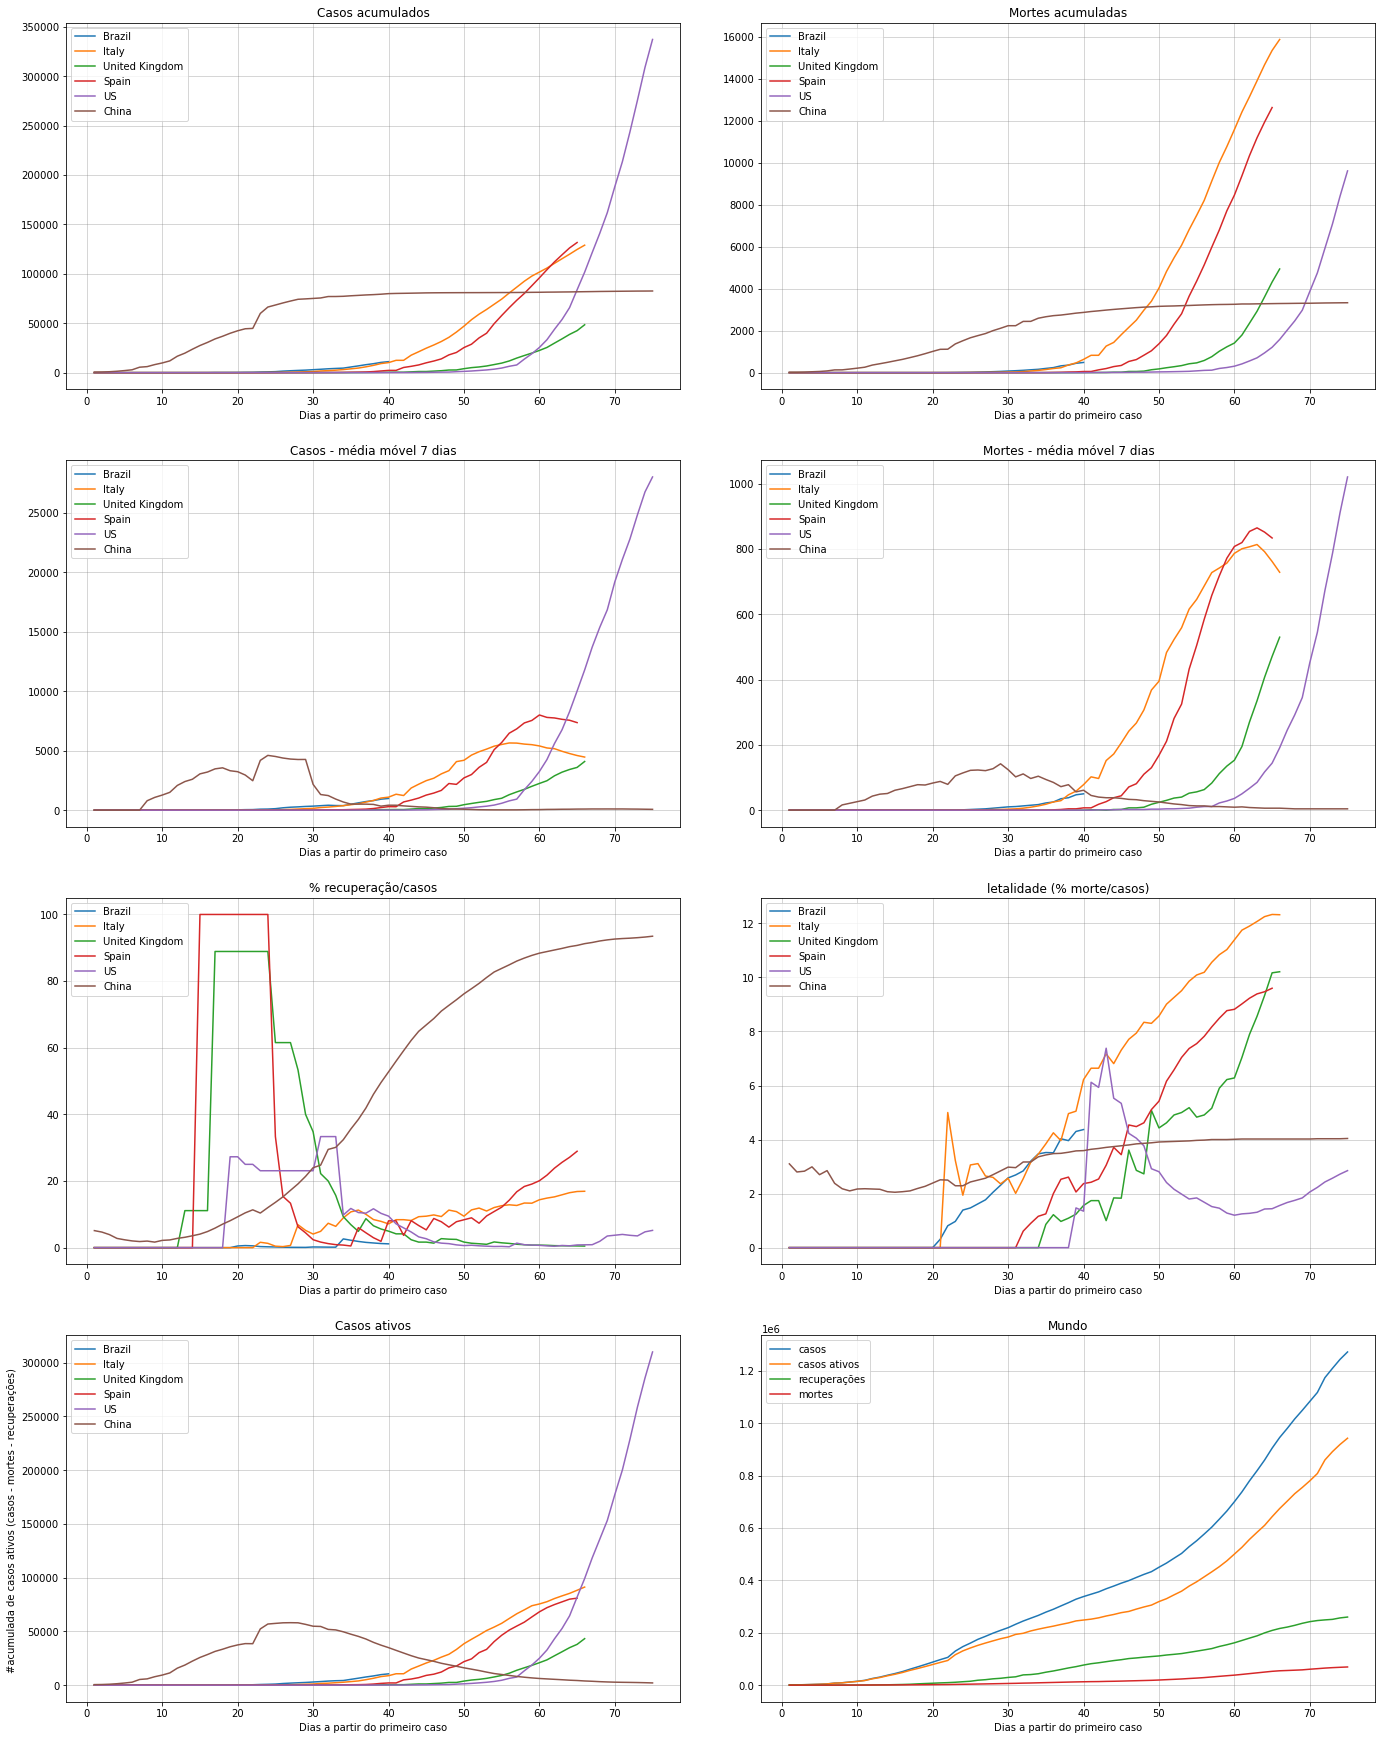

In [6]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(20, 25))
fig.tight_layout(pad=5.0)

ax1.set_title("Casos acumulados")
ax1.set_xlabel("Dias a partir do primeiro caso")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("Mortes acumuladas")
ax2.set_xlabel("Dias a partir do primeiro caso")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("Casos - média móvel 7 dias")
ax3.set_xlabel("Dias a partir do primeiro caso")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("Mortes - média móvel 7 dias")
ax4.set_xlabel("Dias a partir do primeiro caso")
ax4.grid(color='gray', alpha = 0.4)

ax5.set_title("% recuperação/casos")
ax5.set_xlabel("Dias a partir do primeiro caso")
ax5.grid(color='gray', alpha = 0.4)

ax6.set_title("letalidade (% morte/casos)")
ax6.set_xlabel("Dias a partir do primeiro caso")
ax6.grid(color='gray', alpha = 0.4)

ax7.set_title("Casos ativos")
ax7.set_xlabel("Dias a partir do primeiro caso")
ax7.set_ylabel("#acumulada de casos ativos (casos - mortes - recuperações) ")
ax7.grid(color='gray', alpha = 0.4)

ax8.set_title("Mundo")
ax8.set_xlabel("Dias a partir do primeiro caso")
ax8.grid(color='gray', alpha = 0.4)

for pais in paisesMonitorados:
    ax1.plot(df[df['pais'] == pais].dia, df[df['pais'] == pais].casos, label = pais)
    ax2.plot(df[df['pais'] == pais].dia, df[df['pais'] == pais].mortes, label = pais)
    ax3.plot(df[df['pais'] == pais].dia, df[df['pais'] == pais].media7_casos, label = pais)
    ax4.plot(df[df['pais'] == pais].dia, df[df['pais'] == pais].media7_mortes, label = pais)
    ax5.plot(df[df['pais'] == pais].dia, df[df['pais'] == pais].perc_recuperacao, label = pais)
    ax6.plot(df[df['pais'] == pais].dia, df[df['pais'] == pais].perc_morte, label = pais)
    ax7.plot(df[df['pais'] == pais].dia, df[df['pais'] == pais].casos_ativos, label = pais)


dias = np.arange(1, len(df.groupby('dia')['casos'].count())+1,1)
# for dia in dias:
#     caso_mundo.append(df['dia'==dia]['caso'].sum())
casos_mundo = df.groupby('dia')['caso_dia'].sum().to_numpy().cumsum()
mortes_mundo = df.groupby('dia')['morte_dia'].sum().to_numpy().cumsum()
recuperacoes_mundo = df.groupby('dia')['recuperacao_dia'].sum().to_numpy().cumsum()
casos_ativos_mundo = casos_mundo - mortes_mundo - recuperacoes_mundo

ax8.plot(dias, casos_mundo, label = 'casos')
ax8.plot(dias, casos_ativos_mundo, label = 'casos ativos')
ax8.plot(dias, recuperacoes_mundo, label = 'recuperações')
ax8.plot(dias, mortes_mundo, label = 'mortes')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax7.legend()
ax8.legend()

In [7]:
fig.savefig('monitoramento/coronaMundo_' + hoje + '.png')

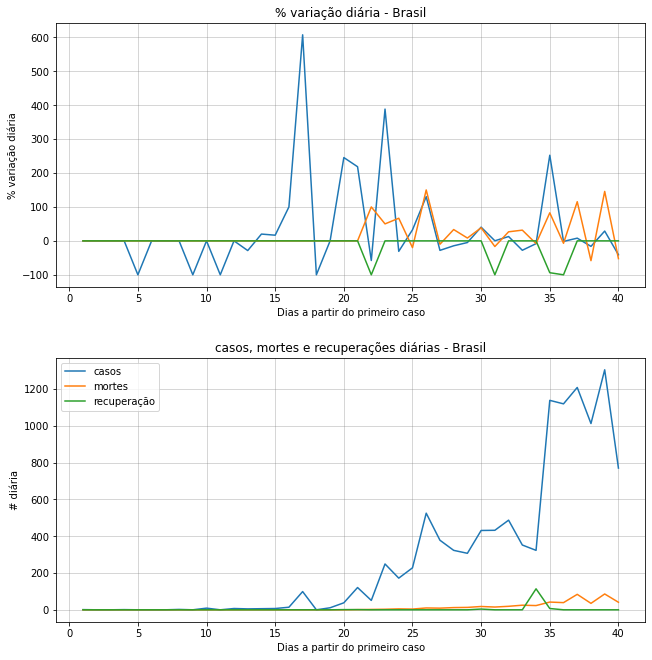

In [8]:
fig, ((ax1, ax2)) = plt.subplots(2,1, figsize=(10, 10))
fig.tight_layout(pad=5.0)
ax1.set_title("% variação diária - Brasil")
ax1.set_xlabel("Dias a partir do primeiro caso")
ax1.set_ylabel("% variação diária")
ax1.grid(color='gray', alpha = 0.4)

df_br = df[df['pais'] == 'Brazil']
ax1.plot(df_br.dia, df_br['%var_caso_dia'], label = 'casos')
ax1.plot(df_br.dia, df_br['%var_morte_dia'], label = 'mortes')
ax1.plot(df_br.dia, df_br['%var_recup_dia'], label = 'recuperação')

ax2.set_title("casos, mortes e recuperações diárias - Brasil")
ax2.set_xlabel("Dias a partir do primeiro caso")
ax2.set_ylabel("# diária")
ax2.grid(color='gray', alpha = 0.4)

ax2.plot(df_br.dia, df_br['caso_dia'], label = 'casos')
ax2.plot(df_br.dia, df_br['morte_dia'], label = 'mortes')
ax2.plot(df_br.dia, df_br['recuperacao_dia'], label = 'recuperação')


# dias = np.arange(1, len(df.groupby('dia')['casos'].count())+1,1)
plt.legend()

## Top 5 - % variação Casos no Mundo

In [9]:
colunas = ['pais','dia','data','casos','caso_dia','mortes','morte_dia', 'media7_casos',  '%var_caso_dia', 'media7_mortes', '%var_morte_dia', '%var_recup_dia']
# df_top = df[df['data']==ontem].nlargest(5,'%var_caso_dia').sort_values('%var_caso_dia', ascending = False)
# df_top = df[df['data']==ontem].nlargest(10,'media7_casos').sort_values('media7_casos', ascending = False)
df_top = df[df['data']==hoje].sort_values('media7_casos', ascending = False)

df_top.reset_index(0, inplace=True)
df_top.index = df_top.index + 1
df_top[colunas].head(20)

,pais,dia,data,casos,caso_dia,mortes,morte_dia,media7_casos,%var_caso_dia,media7_mortes,%var_morte_dia,%var_recup_dia
1,US,75,2020-04-05,337072,28222,9619,1212,28026.0,-15.16,1021.0,-8.18,-43.46
2,France,73,2020-04-05,93773,2925,8093,519,7580.0,-88.59,783.0,-50.76,-45.93
3,Spain,65,2020-04-05,131646,5478,12641,694,7362.0,-21.39,834.0,-7.34,4.18
4,Germany,70,2020-04-05,100123,4031,1584,140,5432.0,-18.29,150.0,-17.16,26.03
5,Italy,66,2020-04-05,128948,4316,15887,525,4465.0,-10.18,729.0,-22.91,-33.84
6,United Kingdom,66,2020-04-05,48436,5959,4943,623,4093.0,57.31,530.0,-12.13,100.00
7,Iran,47,2020-04-05,58226,2483,3603,151,2845.0,-3.01,137.0,-4.43,-100.00
8,Turkey,26,2020-04-05,27069,3135,574,73,2550.0,4.05,63.0,-3.95,-15.23
9,Canada,71,2020-04-05,15756,2778,259,41,1353.0,413.49,27.0,5.13,8.21
10,Belgium,62,2020-04-05,19691,1260,1447,164,1265.0,-24.14,145.0,17.14,34.40


## Top 5 - % variação Mortes no Mundo

In [10]:
# colunas = ['pais','dia','data','casos','caso_dia','mortes','morte_dia', '%var_caso_dia', '%var_morte_dia', '%var_recup_dia']
# df_top = df[df['data']==ontem].nlargest(5,'%var_morte_dia').sort_values('%var_morte_dia', ascending = False)
# df_top = df[df['data']==ontem].nlargest(5,'media7_mortes').sort_values('media7_mortes', ascending = False)
df_top = df[df['data']==hoje].sort_values('media7_mortes', ascending = False)

df_top.reset_index(0, inplace=True)
df_top.index = df_top.index + 1
df_top[colunas].head(20)

,pais,dia,data,casos,caso_dia,mortes,morte_dia,media7_casos,%var_caso_dia,media7_mortes,%var_morte_dia,%var_recup_dia
1,US,75,2020-04-05,337072,28222,9619,1212,28026.0,-15.16,1021.0,-8.18,-43.46
2,Spain,65,2020-04-05,131646,5478,12641,694,7362.0,-21.39,834.0,-7.34,4.18
3,France,73,2020-04-05,93773,2925,8093,519,7580.0,-88.59,783.0,-50.76,-45.93
4,Italy,66,2020-04-05,128948,4316,15887,525,4465.0,-10.18,729.0,-22.91,-33.84
5,United Kingdom,66,2020-04-05,48436,5959,4943,623,4093.0,57.31,530.0,-12.13,100.00
6,Germany,70,2020-04-05,100123,4031,1584,140,5432.0,-18.29,150.0,-17.16,26.03
7,Belgium,62,2020-04-05,19691,1260,1447,164,1265.0,-24.14,145.0,17.14,34.40
8,Netherlands,39,2020-04-05,17953,1226,1771,115,1003.0,35.32,142.0,-30.72,-350.00
9,Iran,47,2020-04-05,58226,2483,3603,151,2845.0,-3.01,137.0,-4.43,-100.00
10,Turkey,26,2020-04-05,27069,3135,574,73,2550.0,4.05,63.0,-3.95,-15.23


In [11]:
df[(df['pais'] == 'Brazil') & (df['data']==ontem)][colunas]

,pais,dia,data,casos,caso_dia,mortes,morte_dia,media7_casos,%var_caso_dia,media7_mortes,%var_morte_dia,%var_recup_dia
765,Brazil,39,2020-04-04,10360,1304,445,86,922.0,28.85,47.0,145.71,0.0


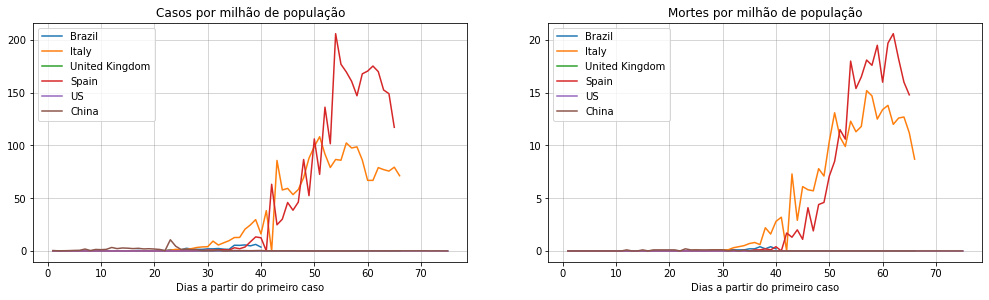

In [12]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15, 5))
fig.tight_layout(pad=5.0)

ax1.set_title("Casos por milhão de população")
ax1.set_xlabel("Dias a partir do primeiro caso")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("Mortes por milhão de população")
ax2.set_xlabel("Dias a partir do primeiro caso")
ax2.grid(color='gray', alpha = 0.4)

for pais in paisesMonitorados:
    ax1.plot(df[df['pais'] == pais].dia, df[df['pais'] == pais].casos_por_milhao, label = pais)
    ax2.plot(df[df['pais'] == pais].dia, df[df['pais'] == pais].mortes_por_milhao, label = pais)

dias = np.arange(1, len(df.groupby('dia')['casos'].count())+1,1)

ax1.legend()
ax2.legend()


---------------------------------------------------------------------
### Previsões

In [13]:
paisesPrevisao = ['Brazil']#, 'Italy', 'United Kingdom', 'Spain', 'US', 'China']#['Brazil']
df_previsoes = pd.DataFrame(columns=['pais','ds', 'caso_dia', 'morte_dia', 'casos', 'mortes'])

for pais in paisesPrevisao:
    # preparando dataset para previsão
    df_pais = df.loc[df['pais'] == pais][['data','pais','caso_dia','morte_dia']]
    df_pais.rename(columns={'data': 'ds'}, inplace= True)
    df_casos = df_pais.loc[:,['ds','caso_dia']]
    df_casos.rename(columns={'caso_dia':'y'}, inplace =True)

    df_mortes = df_pais.loc[:,['ds','morte_dia']]
    df_mortes.rename(columns={'morte_dia':'y'}, inplace =True)
    
    # fiting do modelo e previsão
    m_casos = Prophet(yearly_seasonality=False, daily_seasonality=True, interval_width=0.95)
    m_casos.fit(df_casos)

    m_mortes = Prophet(yearly_seasonality=False, daily_seasonality=True, interval_width=0.95)
    m_mortes.fit(df_mortes)
    
    future_casos = m_casos.make_future_dataframe(periods=10, freq='D', include_history=False)
    future_mortes = m_mortes.make_future_dataframe(periods=10, freq='D', include_history=False)
    
    forecast_casos = m_casos.predict(future_casos)
    forecast_mortes = m_mortes.predict(future_mortes)
    
    #preparação do dataset com previsão
#     df_aux = pd.merge(forecast_casos.loc[:,['ds','yhat']], forecast_mortes.loc[:,['ds','yhat']], how='inner', on=None, left_on='ds', 
#                  right_on='ds', left_index=False, right_index=False, suffixes=('','_y'), sort=False)    
#     df_aux['pais'] = pais
#     df_aux.rename(columns={'yhat': 'caso_dia'}, inplace= True)
#     df_aux.rename(columns={'yhat_y': 'morte_dia'}, inplace= True)
#     df_aux['caso_dia'] = df_aux['caso_dia'].astype('int32')
#     df_aux['morte_dia'] = df_aux['morte_dia'].astype('int32')
#     df_aux['casos'] = df_aux['caso_dia'].cumsum().astype('int32')
#     df_aux['mortes'] = df_aux['morte_dia'].cumsum().astype('int32')
#     df_previsoes = df_previsoes.append(df_aux)
#    df_previsoes = pd.DataFrame(columns=['pais','ds', 'caso_dia', 'morte_dia', 'casos', 'mortes'])
    p = forecast_casos.loc[:,['ds','yhat']]
    p.rename(columns={'yhat': 'y'}, inplace= True)
    t = df_casos.append(p[['ds','y']], ignore_index=True)
    
    p = forecast_mortes.loc[:,['ds','yhat']]
    p.rename(columns={'yhat': 'y'}, inplace= True)
    s = df_mortes.append(p[['ds','y']], ignore_index=True)

    t['ds'] = t['ds'].astype('datetime64[ns]')
    t.rename(columns={'y': 'caso_dia'}, inplace= True)
    t['caso_dia'] = t['caso_dia'].astype('int32')
    t['casos'] = t['caso_dia'].cumsum().astype('int32')
    t['morte_dia'] = s['y'].astype('int32')
    t['mortes'] = t['morte_dia'].cumsum().astype('int32')
    t['pais'] = pais
    t['previsao?'] = t['ds'] >= hoje # para separar o que é previsão (True) do que é dado real (False)
    df_previsoes = df_previsoes.append(t)
    
df_previsoes.to_csv('previsoes/previsaoMundial_' + hoje + '.csv', sep=',', decimal=',', index = False)
df_previsoes.tail(10)

,pais,ds,caso_dia,morte_dia,casos,mortes,previsao?
40,Brazil,2020-04-06,725,34,11855,520,True
41,Brazil,2020-04-07,894,39,12749,559,True
42,Brazil,2020-04-08,921,41,13670,600,True
43,Brazil,2020-04-09,990,50,14660,650,True
44,Brazil,2020-04-10,960,42,15620,692,True
45,Brazil,2020-04-11,1009,51,16629,743,True
46,Brazil,2020-04-12,950,45,17579,788,True
47,Brazil,2020-04-13,918,43,18497,831,True
48,Brazil,2020-04-14,1087,48,19584,879,True
49,Brazil,2020-04-15,1113,51,20697,930,True


In [14]:
df_previsoes.loc[df_previsoes['ds']==hoje]

,pais,ds,caso_dia,morte_dia,casos,mortes,previsao?
39,Brazil,2020-04-05,770,41,11130,486,True


In [15]:
df_previsoes.loc[df_previsoes['ds']==amanha]

,pais,ds,caso_dia,morte_dia,casos,mortes,previsao?
40,Brazil,2020-04-06,725,34,11855,520,True


In [26]:
df_previsoes.tail(26)

,pais,ds,caso_dia,morte_dia,casos,mortes,previsao?
34,Brazil,2020-03-31,1138,42,5717,201,False
35,Brazil,2020-04-01,1119,39,6836,240,False
36,Brazil,2020-04-02,1208,84,8044,324,False
37,Brazil,2020-04-03,1012,35,9056,359,False
38,Brazil,2020-04-04,1304,86,10360,445,False
39,Brazil,2020-04-05,753,34,11113,479,True
40,Brazil,2020-04-06,723,34,11836,513,True
41,Brazil,2020-04-07,892,38,12728,551,True
42,Brazil,2020-04-08,918,41,13646,592,True
43,Brazil,2020-04-09,987,49,14633,641,True


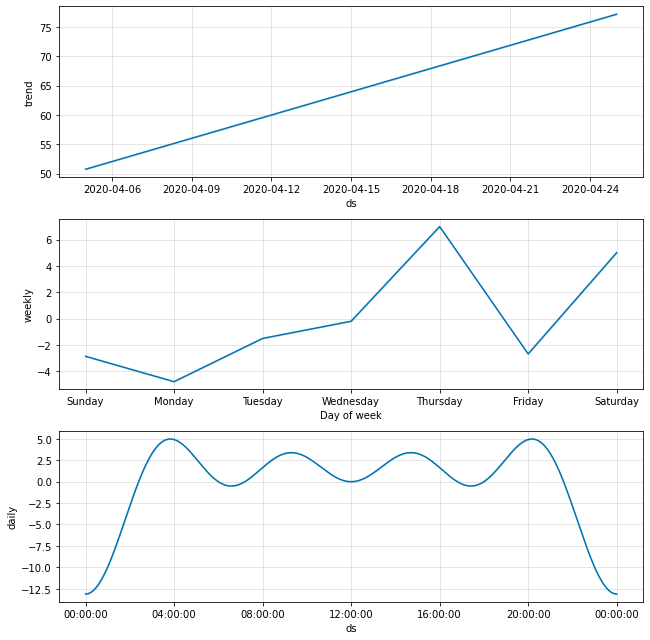

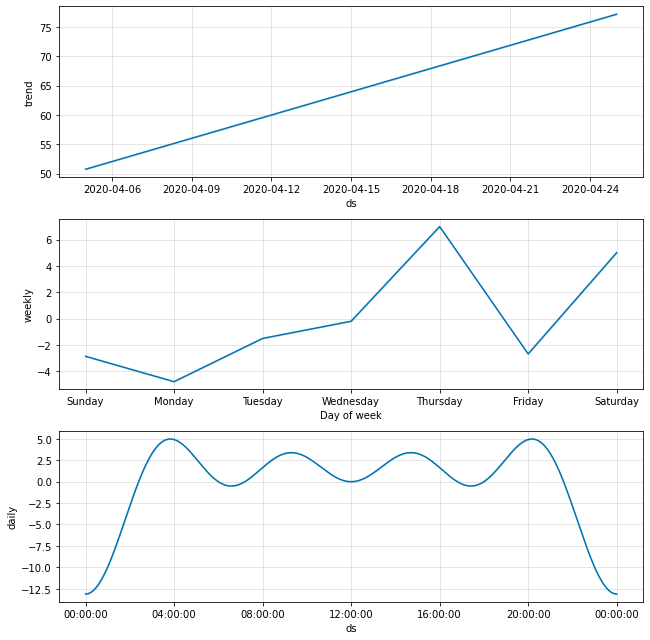

In [30]:
# m_mortes.plot_components(forecast_mortes)

In [39]:
df_previsoes['media7_casos'] = df_previsoes['caso_dia'].rolling(window=7).mean().replace([np.inf, -np.inf], 0).replace([np.nan], 0).astype('int')
df_previsoes['media7_mortes'] = df_previsoes['morte_dia'].rolling(window=7).mean().replace([np.inf, -np.inf], 0).replace([np.nan], 0).astype('int')
df_previsoes

,pais,ds,caso_dia,morte_dia,casos,mortes,previsao?,media7_casos,media7_mortes
0,Brazil,2020-02-26,1,0,1,0,False,0,0
1,Brazil,2020-02-27,0,0,1,0,False,0,0
2,Brazil,2020-02-28,0,0,1,0,False,0,0
3,Brazil,2020-02-29,1,0,2,0,False,0,0
4,Brazil,2020-03-01,0,0,2,0,False,0,0
...,...,...,...,...,...,...,...,...,...
64,Brazil,2020-04-30,1562,77,40249,1838,True,1411,66
65,Brazil,2020-05-01,1533,69,41782,1907,True,1438,67
66,Brazil,2020-05-02,1582,78,43364,1985,True,1466,68
67,Brazil,2020-05-03,1520,71,44884,2056,True,1493,70


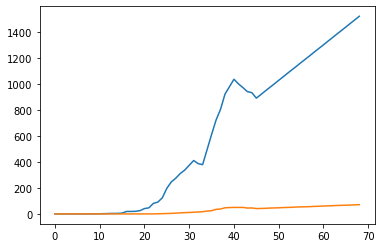

In [43]:
plt.plot(df_previsoes['media7_casos'])
plt.plot(df_previsoes['media7_mortes'])
